In [183]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource, LinearColorMapper, LogColorMapper
from bokeh.transform import factor_cmap
from bokeh.palettes import Colorblind, Magma256

output_notebook()
palette = Colorblind[8]
palette_gradient = Magma256

spalette = sns.color_palette()

Loading BokehJS ...

In [174]:
df_iterations = pd.read_csv("../results.renaissance.full.20220429-192302.csv")
df_iterations

,benchmark,runid,type,pair,order,iteration,epoch_start_ms,iteration_time_ns,iteration_start_ns,iteration_end_ns
0,fj-kmeans,1,duet,A,BA,0,1651263055306,10986394100,1651263055306000000,1651263066292394100
1,fj-kmeans,1,duet,A,BA,1,1651263055306,10205578900,1651263066292394100,1651263076497973000
2,fj-kmeans,1,duet,A,BA,2,1651263055306,9987265000,1651263076497973000,1651263086485238000
3,fj-kmeans,1,duet,A,BA,3,1651263055306,10056811200,1651263086485238000,1651263096542049200
4,fj-kmeans,1,duet,A,BA,4,1651263055306,10039607300,1651263096542049200,1651263106581656500
...,...,...,...,...,...,...,...,...,...,...
5835,chi-square,1,sequential,A,BA,55,1651254910603,1089163700,1651254975866727200,1651254976955890900
5836,chi-square,1,sequential,A,BA,56,1651254910603,1105807300,1651254976955890900,1651254978061698200
5837,chi-square,1,sequential,A,BA,57,1651254910603,1067194300,1651254978061698200,1651254979128892500
5838,chi-square,1,sequential,A,BA,58,1651254910603,1096635900,1651254979128892500,1651254980225528400


# Timeline

Just check the high level timeline, i.e. whether the script did what it meant to do.

In [181]:
value_cols = ["iteration_start_ns", "iteration_end_ns"]
id_cols = list(set(df_iterations.columns) - set(value_cols))
df_iterations_melt = df_iterations.melt(id_vars=id_cols, value_vars=value_cols, var_name="start/end", value_name="time_ns")
df_iterations_melt["time"] = pd.to_datetime(df_iterations_melt["time_ns"], unit='ns')
df_iterations_melt

,runid,iteration,type,benchmark,epoch_start_ms,iteration_time_ns,order,pair,start/end,time_ns,time
0,1,0,duet,fj-kmeans,1651263055306,10986394100,BA,A,iteration_start_ns,1651263055306000000,2022-04-29 20:10:55.306000000
1,1,1,duet,fj-kmeans,1651263055306,10205578900,BA,A,iteration_start_ns,1651263066292394100,2022-04-29 20:11:06.292394100
2,1,2,duet,fj-kmeans,1651263055306,9987265000,BA,A,iteration_start_ns,1651263076497973000,2022-04-29 20:11:16.497973000
3,1,3,duet,fj-kmeans,1651263055306,10056811200,BA,A,iteration_start_ns,1651263086485238000,2022-04-29 20:11:26.485238000
4,1,4,duet,fj-kmeans,1651263055306,10039607300,BA,A,iteration_start_ns,1651263096542049200,2022-04-29 20:11:36.542049200
...,...,...,...,...,...,...,...,...,...,...,...
11675,1,55,sequential,chi-square,1651254910603,1089163700,BA,A,iteration_end_ns,1651254976955890900,2022-04-29 17:56:16.955890900
11676,1,56,sequential,chi-square,1651254910603,1105807300,BA,A,iteration_end_ns,1651254978061698200,2022-04-29 17:56:18.061698200
11677,1,57,sequential,chi-square,1651254910603,1067194300,BA,A,iteration_end_ns,1651254979128892500,2022-04-29 17:56:19.128892500
11678,1,58,sequential,chi-square,1651254910603,1096635900,BA,A,iteration_end_ns,1651254980225528400,2022-04-29 17:56:20.225528400


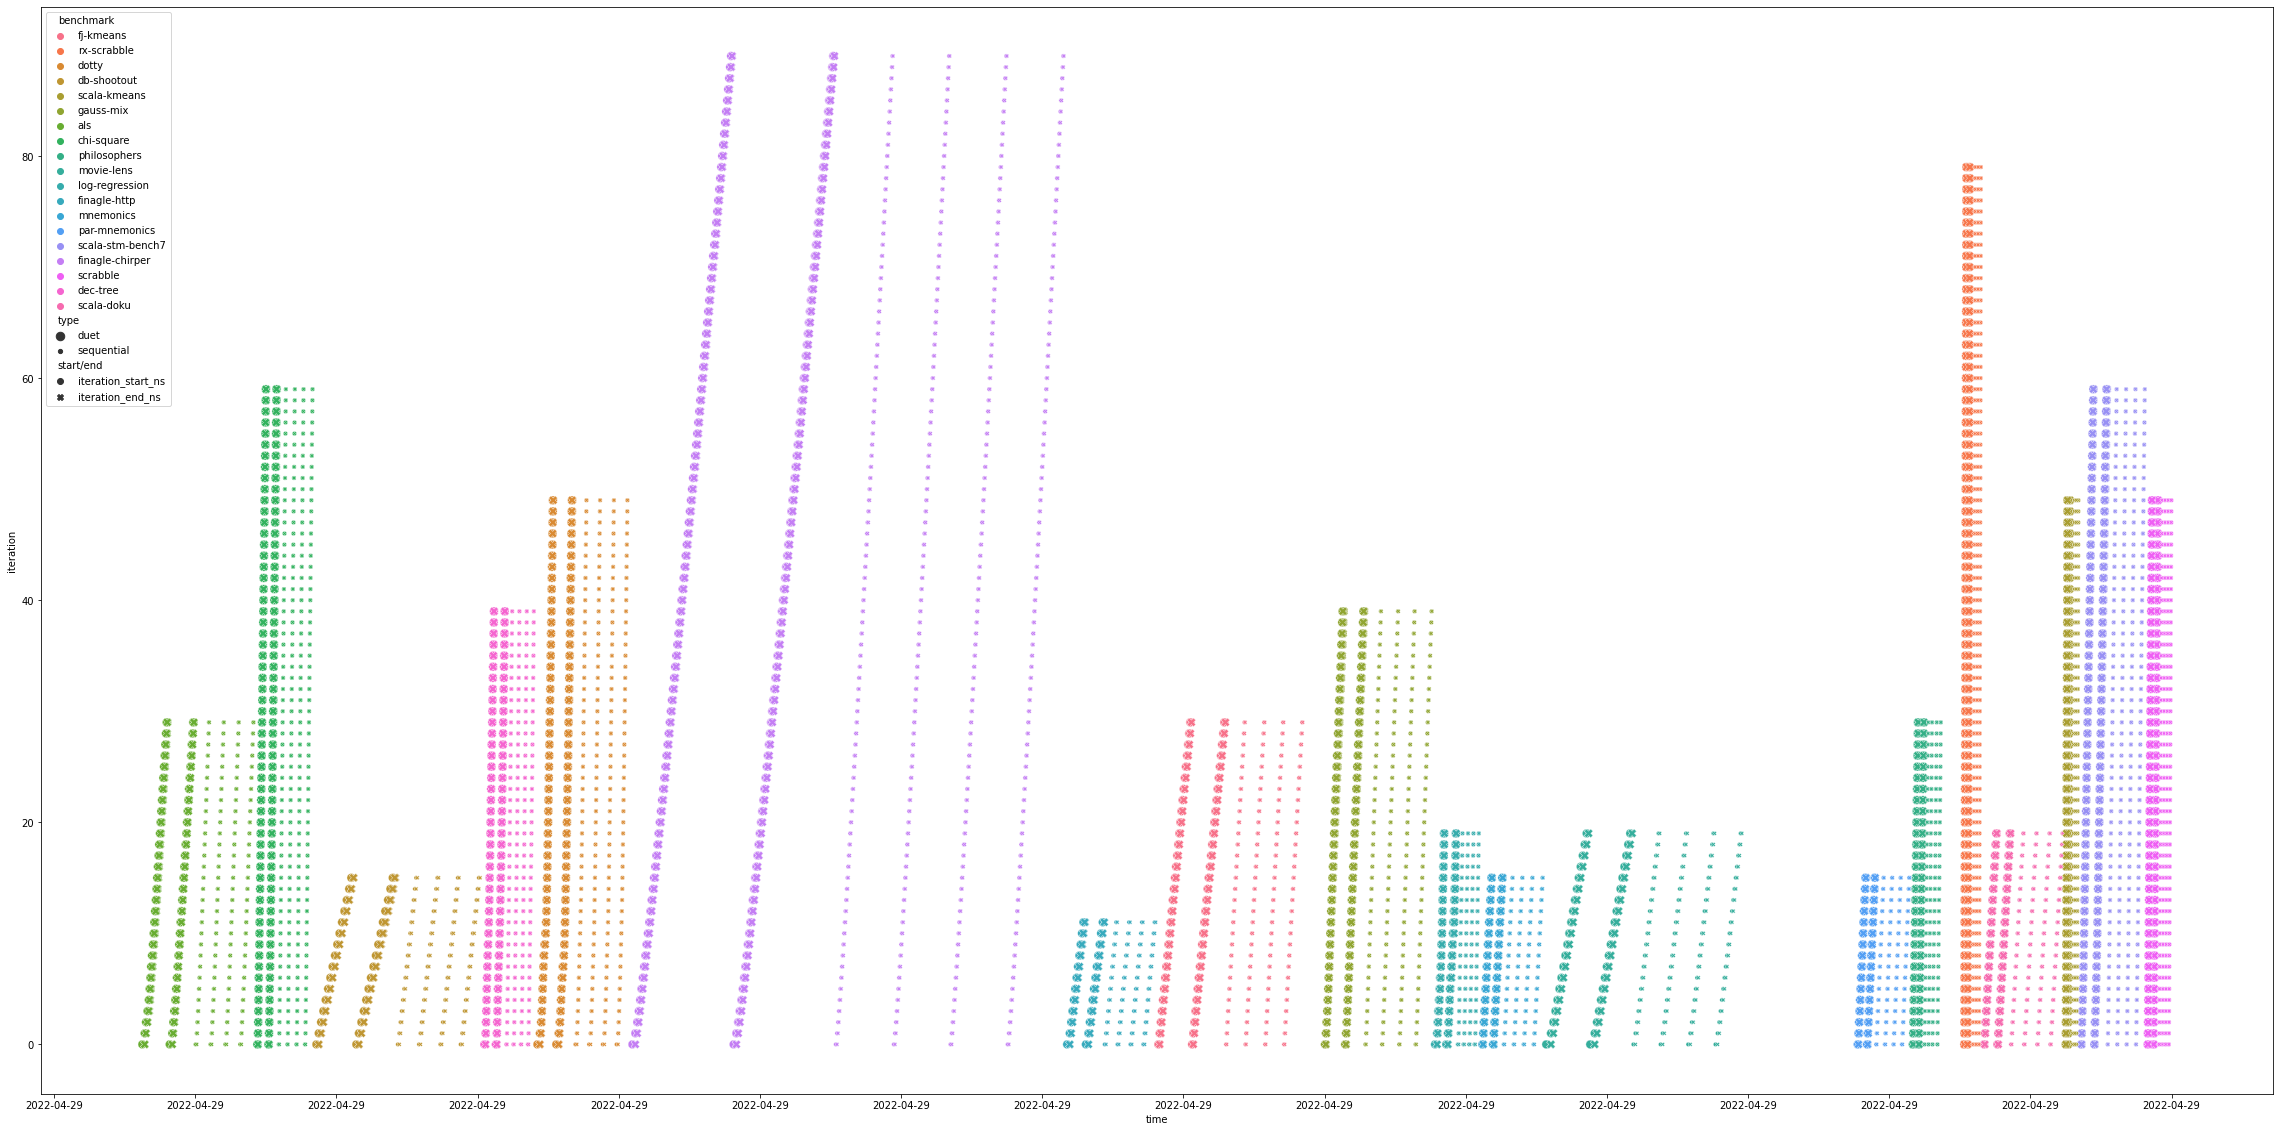

In [190]:
plt.figure(figsize=(40,20))
ax = sns.scatterplot(x="time", y="iteration", hue="benchmark", style="start/end", size="type",
    data=df_iterations_melt # [df_iterations_melt.benchmark.isin(["chi-square"])]
)
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=df_iterations["benchmark"].nunique()))


   category    type  time  value  overlaps  start   end      xrange
0         A  xstart     0      1         1      0   0.0    (0, 0.0)
4         A  xstart     0      1         2      0   5.0    (0, 5.0)
12        A    xend     5     -1         1      5  10.0    (5, 5.0)
13        A    xend    15     -1        -1     15  20.0   (15, 5.0)
5         A  xstart    20      1         1     20  20.0   (20, 0.0)
14        A    xend    25     -1        -1     25  30.0   (25, 5.0)
10        A    xend    30     -1        -2     30  35.0   (30, 5.0)
15        A    xend    35     -1        -3     35  40.0   (35, 5.0)
2         A  xstart    40      1        -2     40  40.0   (40, 0.0)
6         A  xstart    40      1        -1     40  40.0   (40, 0.0)
11        A    xend    40     -1        -2     40  60.0  (40, 20.0)
3         A  xstart    60      1        -1     60  60.0   (60, 0.0)
None


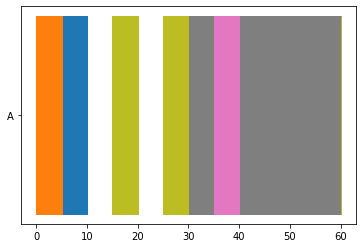

In [281]:
xstart = "start"
xend = "end"
category = "pair"
n = 4
df = pd.DataFrame({
    xstart: [i * 20 for i in range(n)],
    xend: [(i + 1) * 20 - 10 for i in range(n)],
    category: "A"
})

df = pd.concat([
    df,
    pd.DataFrame({
        xstart: [i * 20 for i in range(n)],
        xend: [(i + 1) * 10 - 5 for i in range(n)],
        category: "A"
    })
])

def overlapplot(xstart, xend, ycategory, data: pd.DataFrame=None):
    yheight = 1

    df_intervals = pd.DataFrame()
    df_intervals["xstart"] = xstart if data is None else data[xstart]
    df_intervals["xend"] = xend if data is None else data[xend]
    df_intervals["category"] = ycategory if data is None else data[ycategory]

    categories = data[ycategory].unique()

    df_boxes = df_intervals.melt(id_vars=["category"], var_name="type", value_vars=["xstart", "xend"], value_name="time")
    df_boxes["value"] = np.select([df_boxes["type"] == "xstart", df_boxes["type"] == "xend"], [1, -1])
    df_boxes["overlaps"] = df_boxes.sort_values(by=["category", "time"]).groupby("category")["value"].cumsum()
    df_boxes["start"] = df_boxes["time"]
    df_boxes["end"] = df_boxes.sort_values(by=["category", "time"]).groupby("category")["time"].shift(-1, fill_value=None)
    df_boxes.dropna(inplace=True)
    df_boxes.drop(df_boxes[df_boxes["overlaps"] == 0].index, inplace=True)
    df_boxes["xrange"] = df_boxes.apply(lambda row: (row["start"], row["end"] - row["start"]), axis=1)

    print(df_boxes.sort_values(by=["category", "time"]))

    fig, ax = plt.subplots()
    for overlap in df_boxes["overlaps"].unique():
        color = spalette[overlap - 1]
        for category_idx, category in enumerate(categories):
            xranges = df_boxes[(df_boxes["category"] == category) & (df_boxes["overlaps"] == overlap)]["xrange"]
            ax.broken_barh(xranges, yrange=(category_idx, yheight), color=color)

    ax.set_yticks([i + yheight / 2 for i in range(len(categories))], labels=categories)

print(overlapplot(xstart, xend, category, df))
#df[df[category] == "B"][xstart]

## Overlapping timeline

In [ ]:
df_start_end = df_iterations.pivot_table(index=["benchmark", "runid", "iteration"], columns="pair", values=["iteration_start_ns", "iteration_end_ns"])
df_start_end

iteration_end_ns                       \
pair                                         A                    B   
benchmark runid iteration                                             
als       0     0          1651253678640812032  1651253747257307392   
                1          1651253687220146176  1651253755768094208   
                2          1651253697138398720  1651253765557795840   
                3          1651253704992425472  1651253775761128704   
                4          1651253710759815424  1651253782525003520   
...                                        ...                  ...   
scrabble  1     45         1651271981640635648  1651271968962420224   
                46         1651271982211976960  1651271969565743616   
                47         1651271982821774336  1651271970003633408   
                48         1651271983444567040  1651271970433482240   
                49         1651271984025944064  1651271970914548224   

                            iteration_start_ns                       
pair                                         A                    B  
benchmark runid iteration                                            
als       0     0          1651253662128000000  1651253730430000128  
                1          1651253678640812032  1651253747257307392  
                2          1651253687220146176  1651253755768094208  
                3          1651253697138398720  1651253765557795840  
                4          1651253704992425472  1651253775761128704  
...                                        ...                  ...  
scrabble  1     45         1651271981017592832  1651271968331866624  
                46         1651271981640635648  1651271968962420224  
                47         1651271982211976960  1651271969565743616  
                48         1651271982821774336  1651271970003633408  
                49         1651271983444567040  1651271970433482240  

[1460 rows x 4 columns]

In [ ]:
columns_of_interest = [
    "benchmark",
    "pair",
    "runid",
    "iteration",
    "iteration_time_ns",
    "iteration_start_ns",
    "iteration_end_ns",
]
df = df_iterations[columns_of_interest]

# Compute overlap interval
df_overlap = df[df.pair == "A"].merge(
    df[df.pair == "B"], on=["benchmark", "runid"], suffixes=["_A", "_B"], how="inner"
)
df_overlap["overlap_start_ns"] = df_overlap[
    ["iteration_start_ns_A", "iteration_start_ns_B"]
].max(axis=1)
df_overlap["overlap_end_ns"] = df_overlap[
    ["iteration_end_ns_A", "iteration_end_ns_B"]
].min(axis=1)

df_overlap.drop(["pair_A", "pair_B"], axis=1, inplace=True)

# Filter out non overlapping intervals
df_overlap["overlap"] = df_overlap["overlap_start_ns"].lt(df_overlap["overlap_end_ns"])
df_overlap = df_overlap[df_overlap["overlap"] == True]
df_overlap.reset_index(drop=True, inplace=True)

# Compute overlap properties
df_overlap["overlap_size"] = (
    df_overlap["overlap_end_ns"] - df_overlap["overlap_start_ns"]
)
df_overlap["overlap_proportion_A"] = (
    df_overlap["overlap_size"] / df_overlap["iteration_time_ns_A"]
)
df_overlap["overlap_proportion_B"] = (
    df_overlap["overlap_size"] / df_overlap["iteration_time_ns_B"]
)
df_overlap["iteration_difference_time_ns"] = (
    df_overlap["iteration_time_ns_A"] - df_overlap["iteration_time_ns_B"]
)
df_overlap["iteration_difference_time_ns_size_weighted"] = (
    df_overlap["iteration_time_ns_A"] - df_overlap["iteration_time_ns_B"]
) * df_overlap["overlap_size"]
df_overlap["iteration_difference_time_ns_proportion_weighted"] = (
    df_overlap["iteration_time_ns_A"] - df_overlap["iteration_time_ns_B"]
) * df_overlap["overlap_proportion_A"]
df_overlap["iteration_difference_time_ns_scaled"] = (
    df_overlap["iteration_time_ns_A"] - df_overlap["iteration_time_ns_B"]
) / df_overlap["iteration_time_ns_A"]
df_overlap["iteration_difference_time_ns_scaled_size_weighted"] = (
    (df_overlap["iteration_time_ns_A"] - df_overlap["iteration_time_ns_B"])
    / df_overlap["iteration_time_ns_A"]
) * df_overlap["overlap_size"]
df_overlap["iteration_difference_time_ns_scaled_proportion_weighted"] = (
    (df_overlap["iteration_time_ns_A"] - df_overlap["iteration_time_ns_B"])
    / df_overlap["iteration_time_ns_A"]
) * df_overlap["overlap_proportion_A"]

df_overlap

,benchmark,runid,iteration_A,iteration_time_ns_A,iteration_start_ns_A,iteration_end_ns_A,iteration_B,iteration_time_ns_B,iteration_start_ns_B,iteration_end_ns_B,...,overlap,overlap_size,overlap_proportion_A,overlap_proportion_B,iteration_difference_time_ns,iteration_difference_time_ns_size_weighted,iteration_difference_time_ns_proportion_weighted,iteration_difference_time_ns_scaled,iteration_difference_time_ns_scaled_size_weighted,iteration_difference_time_ns_scaled_proportion_weighted
0,fj-kmeans,1,0,10986394100,1651263055306000000,1651263066292394100,0,11154228800,1651263055304000000,1651263066458228800,...,True,10986394100,1.000000,0.984953,-167834700,-1843898157855270000,-1.678347e+08,-0.015277,-1.678347e+08,-0.015277
1,fj-kmeans,1,1,10205578900,1651263066292394100,1651263076497973000,0,11154228800,1651263055304000000,1651263066458228800,...,True,165834700,0.016249,0.014867,-948649900,-157319071571530000,-1.541501e+07,-0.092954,-1.541501e+07,-0.001510
2,fj-kmeans,1,1,10205578900,1651263066292394100,1651263076497973000,1,10194365400,1651263066458228800,1651263076652594200,...,True,10039744200,0.983751,0.984833,11213500,112580671586700000,1.103129e+07,0.001099,1.103129e+07,0.001081
3,fj-kmeans,1,2,9987265000,1651263076497973000,1651263086485238000,1,10194365400,1651263066458228800,1651263076652594200,...,True,154621200,0.015482,0.015167,-207100400,-32022112368480000,-3.206294e+06,-0.020736,-3.206294e+06,-0.000321
4,fj-kmeans,1,2,9987265000,1651263076497973000,1651263086485238000,2,10036285400,1651263076652594200,1651263086688879600,...,True,9832643800,0.984518,0.979709,-49020400,-482000132133520000,-4.826147e+07,-0.004908,-4.826147e+07,-0.004832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2846,gauss-mix,0,37,3753383500,1651264428293904300,1651264432047287800,35,4145845700,1651264429997675400,1651264434143521100,...,True,2049612400,0.546071,0.494377,-392462200,-804395391651280000,-2.143121e+08,-0.104562,-2.143121e+08,-0.057098
2847,gauss-mix,0,38,3765342900,1651264432047287800,1651264435812630700,35,4145845700,1651264429997675400,1651264434143521100,...,True,2096233300,0.556718,0.505623,-380502800,-797622640103240000,-2.118327e+08,-0.101054,-2.118327e+08,-0.056259
2848,gauss-mix,0,38,3765342900,1651264432047287800,1651264435812630700,36,4079170500,1651264434143521100,1651264438222691600,...,True,1669109600,0.443282,0.409179,-313827600,-523812659904960000,-1.391142e+08,-0.083346,-1.391142e+08,-0.036946
2849,gauss-mix,0,39,3813037800,1651264435812630700,1651264439625668500,36,4079170500,1651264434143521100,1651264438222691600,...,True,2410060900,0.632058,0.590821,-266132700,-641396014481430000,-1.682113e+08,-0.069795,-1.682113e+08,-0.044115


In [ ]:
df_overlap[
    [
        "iteration_time_ns_A",
        "iteration_time_ns_B",
        "overlap_size",
        "iteration_difference_time_ns",
        "iteration_difference_time_ns_size_weighted",
        "iteration_difference_time_ns_proportion_weighted",
        "iteration_difference_time_ns_scaled_size_weighted",
        "iteration_difference_time_ns_scaled_proportion_weighted",
    ]
].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
iteration_time_ns_A,38.0,3.371593e+09,1.717970e+09,2.187567e+09,2.517497e+09,2.608907e+09,3.377355e+09,8.490486e+09
iteration_time_ns_B,38.0,3.074104e+09,1.223829e+09,2.198676e+09,2.481123e+09,2.620566e+09,3.284485e+09,7.859116e+09
overlap_size,38.0,1.734728e+09,1.813089e+09,4.391328e+07,3.628466e+08,1.792550e+09,2.494451e+09,7.859116e+09
iteration_difference_time_ns,38.0,2.974895e+08,9.864462e+08,-4.096375e+08,-9.648409e+07,2.893618e+07,1.996877e+08,4.292191e+09
iteration_difference_time_ns_size_weighted,38.0,2.790818e+17,1.065537e+18,-1.506675e+18,-4.335288e+16,3.029023e+16,2.122457e+17,4.962013e+18
iteration_difference_time_ns_proportion_weighted,38.0,3.004815e+07,1.628219e+08,-3.966843e+08,-1.633213e+07,1.205214e+07,6.715044e+07,5.844204e+08
iteration_difference_time_ns_scaled_size_weighted,38.0,3.004815e+07,1.628219e+08,-3.966843e+08,-1.633213e+07,1.205214e+07,6.715044e+07,5.844204e+08
iteration_difference_time_ns_scaled_proportion_weighted,38.0,2.310344e-03,3.938346e-02,-1.136249e-01,-6.378487e-03,4.268005e-03,2.049474e-02,7.024637e-02


In [ ]:
source = ColumnDataSource(df_overlap)
p = figure()
p.hbar(
    y="index",
    left="overlap_start_ns",
    right="overlap_end_ns",
    source=source,
    color={
        "field": "overlap_size",
        "transform": LogColorMapper(palette=palette_gradient),
    },
)

show(p)

In [ ]:
source = ColumnDataSource(df_overlap)
p = figure()
p.vbar(x="overlap_start_ns", top="overlap_size", source=source)

show(p)